In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

In [85]:
labels = {"No One": "None",
          "Distillation (distilbert)": "Know. Distil.",
          "Pruning 0.2": "Pruning (0.2)",
            "Pruning 0.4": "Pruning (0.4)",
            "Pruning 0.6": "Pruning (0.6)",
            'Quantization  (quanto-qfloat8)': "Quantization (float8)",
            'Quantization (quanto-qfloat8)': "Quantization (float8)",
            'Quantization  (quanto-qint8)': "Quantization (int8)",
            'Quantization (quanto-qint8)': "Quantization (int8)",
            'Quantization  (quanto-qint4)': "Quantization (int4)",
            'Quantization (quanto-qint4)': "Quantization (int4)" }

stat_labels = {
    "distil": "Know. Distil.",
    "prune": "Pruning (0.2)",
    "prune4": "Pruning (0.4)",
    "prune6": "Pruning (0.6)",
    "quantf8": "Quantization (float8)",
    "quant": "Quantization (int8)",
    "quant4": "Quantization (int4)",
}

df = pd.read_csv('experiment_values.csv', delimiter=';')

stat = pd.read_csv("lat_comparison_median.csv")
stat["Compression Method"] = stat["Compression Method"].map(stat_labels)

df["Compression Method"] = df["Compression Method"].map(labels)

methods_order = ["None"] + sorted([cm for cm in df["Compression Method"].unique() if cm != "None"])

In [86]:
def make_tables(df_, stat, acc_metrics):
    table = df_[acc_metrics].copy(deep=True)
    # replace the highest values of each column with \textbf{value}

    for metric in table.columns:
        # calculate the percentage change
        perc = ((table[metric] / table.loc["None", metric] * 100) - 100).map(
            lambda x: f"{x:+.1f}\%"
        )
        # find best and worst values
        best = table[metric].idxmax()
        worst = table[metric].idxmin()
        # top_2 = table.loc[methods_order[1:], metric].sort_values(ascending=False)[:2]
        # format the values
        table.loc[:, metric] = table[metric].map(lambda x: f"{x:.3f}")
        # the highest value is bold
        table.loc[best, metric] = (
            "\\textbf{" + table.loc[best, metric] + "}"
        )
        # the second highest value is underlined
        table.loc[worst, metric] = (
            "\\underline{" + table.loc[worst, metric] + "}"
        )
        # add the percentage change
        table.loc[methods_order[1:], metric] =  perc 

    table.reset_index(inplace=True)

    table.rename(columns={c: "\\textbf{" + c + "}" for c in table.columns}, inplace=True)

    stat_cpu = stat[stat['platform'] == 'cpu']
    stat_cuda = stat[stat['platform'] == 'cuda']
    table_eff = pd.DataFrame(
        columns=["Compression Method","Inference Time CPU", "Inference Time GPU", "Model Size"]
    )

    for method in df_.index:

        if method == "None":
            table_eff = pd.concat(
                [
                    table_eff,
                    pd.DataFrame(
                        {
                            "Compression Method": [method],
                            "Inference Time CPU": format(df_.loc[method]["Median Inference Time CPU"], ".3f") + " (sec)",
                            "Inference Time GPU": format(df_.loc[method]["Median Inference Time CUDA"],".3f") + " (sec)",
                            "Model Size": format(df_.loc[method]["Model Size"],".0f") + " (MB)",
                        }
                    ),
                ]
            )
        else:
            table_eff = pd.concat(
              [
                  table_eff,
                  pd.DataFrame(
                      {
                          "Compression Method": [method],
                          "Inference Time CPU": str(
                              stat_cpu[stat_cpu["Compression Method"] == method]["median"]
                              .map(lambda x: f"{x:.1f}\%")
                              .values[0]
                          )
                          + " $\pm$ "
                          + stat_cpu[stat_cpu["Compression Method"] == method][
                              "uncertainty"
                          ]
                          .map(lambda x: f"{x:.1f}\%")
                          .values[0],
                          "Inference Time GPU": str(
                              stat_cuda[stat_cuda["Compression Method"] == method]["median"]
                              .map(lambda x: f"{x:.1f}\%")
                              .values[0]
                          )
                          + " $\pm$ "
                          + stat_cuda[stat_cuda["Compression Method"] == method][
                              "uncertainty"
                          ]
                          .map(lambda x: f"{x:.1f}\%")
                          .values[0],
                          "Model Size":  str(
                              format((df_.loc[method]["Model Size"] / df_.loc["None"]["Model Size"] * 100 - 100), ".1f")) + "\%",
                      }
                  ),
              ]
          )

    for metric in table_eff.columns:
        if table_eff[metric].dtype == "float64":
            best = table_eff[metric].idxmin()
            worst = table_eff[metric].idxmax()
            table_eff.loc[best, metric] = "\\textbf{" + table_eff.loc[best, metric] + "}"
            table_eff.loc[worst, metric] = "\\underline{" + table_eff.loc[worst, metric] + "}"

    # table_eff = df_[
    #     ["Avg Inference Time CPU", "Avg Inference Time CUDA", "Model Size"]
    # ].copy(deep=True)
    # for metric in  table_eff.columns:
    #     perc = ((table_eff[metric] / table_eff.loc["None", metric] * 100) - 100).map(lambda x: f"{x:+.1f}\%")
    #     #top_2 = table_eff.loc[methods_order[1:], metric].sort_values(ascending=True)[:2]
    #     best = table_eff[metric].idxmin()
    #     worst = table_eff[metric].idxmax()
    #     if metric == "Model Size":
    #         table_eff.loc[:, metric] = table_eff[metric].map(lambda x: f"{x:.0f}")
    #     elif metric == "Avg Inference Time CUDA":
    #         table_eff.loc[:, metric] = table_eff[metric].map(lambda x: f"{x:.3f}")
    #     else:
    #         table_eff.loc[:, metric] = table_eff[metric].map(lambda x: f"{x:.2f}")

    #     table_eff.loc[best, metric] = "\\textbf{" + table_eff.loc[best, metric] + "}"
    #     table_eff.loc[worst, metric] = "\\underline{" + table_eff.loc[worst, metric] + "}"

    #     table_eff.loc[methods_order[1:], metric] = table_eff.loc[methods_order, metric] + " (" + perc + ")"
    table_eff.rename(columns={c: "\\textbf{" + c + "}" for c in table_eff.columns}, inplace=True)

    return table, table_eff

# Defect Prediction

In [87]:
df_ = df[df['Task'] == 'Defect Prediction']

df_ = df_.pivot(index='Compression Method', columns='Parameter', values='Value')
df_ = df_.reindex(methods_order)

df_["Method"] = df_.index.map(lambda x: "Pruning" if x.startswith("Pruning") else ("Quantization" if x.startswith("Quantization")  else x))

stat_cc = stat[stat['task'] == 'cc']

In [88]:
df_

Parameter,Accuracy,Avg Inference Time CPU,Avg Inference Time CUDA,F1,MCC,Median Inference Time CPU,Median Inference Time CUDA,Model Size,Method
Compression Method,,,,,,,,,
None,0.630,15.439,0.010,0.541,0.247,15.902356,0.011143,498.658348,None
Know. Distil.,0.616,9.068,0.005,0.558,0.222,9.122519,0.005575,255.440000,Know. Distil.
Pruning (0.2),0.602,18.451,0.014,0.319,0.219,18.380598,0.011723,498.655532,Pruning
Pruning (0.4),0.584,18.815,0.011,0.211,0.196,18.828698,0.011338,498.655532,Pruning
Pruning (0.6),0.593,5.824,0.011,0.275,0.202,5.585062,0.011871,498.655532,Pruning
Quantization (float8),0.630,25.321,0.021,0.535,0.248,23.373236,0.021454,242.538956,Quantization
Quantization (int4),0.620,35.979,0.030,0.517,0.226,41.683454,0.032724,202.830864,Quantization
Quantization (int8),0.627,31.464,0.019,0.536,0.241,33.897889,0.022159,242.538700,Quantization


## Tables

In [89]:
table, table_eff = make_tables(df_, stat_cc, ["Accuracy", "F1", "MCC"])

table.to_latex("tables/defect_prediction_acc.tex", escape=False, index=False)
table_eff.to_latex("tables/defect_prediction_time_size_median.tex", escape=False, index=False)
df_.reset_index(inplace=True)

In [90]:
acronyms = {"None": "N",
            "Pruning (0.2)": "P.2",
            "Pruning (0.4)": "P.4",
            "Pruning (0.6)": "P.6",
            "Quantization (float8)": "QF8",
            "Quantization (int8)": "QI8",
            "Quantization (int4)": "QI4",
            "Know. Distil.": "KD"
            }

xlabels = {
    "Median Inference Time CPU": "Inference Time (CPU) [sec.]",
    "Median Inference Time CUDA": "Inference Time (GPU) [sec.]",
    "Model Size": "Model Size [MB]",
}

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_4723/733736742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_4723/733736742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])


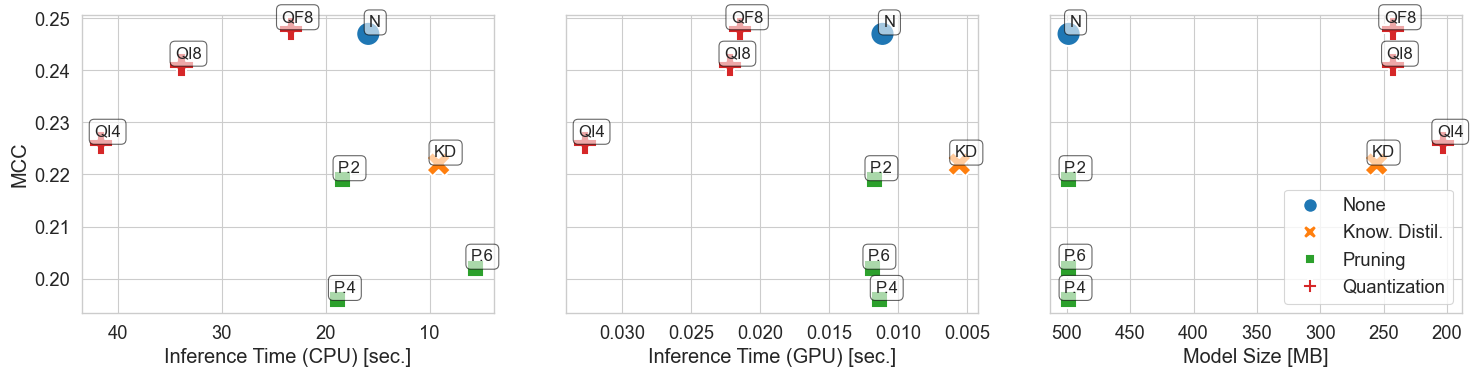

In [91]:

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for metric, ax in zip(
  ["Median Inference Time CPU", "Median Inference Time CUDA", "Model Size"], axs
):
    if metric != "Median Inference Time CPU":
        # hide y label and ticks labels
        ax.set_yticklabels(["" for i in ax.get_yticklabels()])
        ax.set_ylabel(" ")

    sns.scatterplot(
      data=df_,
      x=metric,
      y="MCC",
      hue="Method",
      # style="Method",
      ax=ax,
      legend=(metric == "Model Size"),
      s=300,
      #palette="inferno",
      style="Method"
  )

    # remove the legend title if it exists
    # reduce size of the legend symbols

    if metric == "Model Size":
        ax.legend(title=None, markerscale=0.6)

    # reverse the x-axis
    ax.invert_xaxis()
    ax.set_xlabel(xlabels[metric])

    # add the acronyms to the plot
    for i, row in df_.iterrows():
        # center on the point and white font
        ax.annotate(
            acronyms[row["Compression Method"]],
            (row[metric], row["MCC"]),
            textcoords="offset points", xytext=(5, 5), ha='center', fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.3')
        )

plt.tight_layout()
plt.savefig("figures/defect_prediction_tradeoff.pdf")

# Code Summarization

In [92]:
df_ = df[df["Task"] == "Summarization"]

df_ = df_.pivot(index="Compression Method", columns="Parameter", values="Value")
df_ = df_.reindex(methods_order)

df_["Method"] = df_.index.map(
    lambda x: (
        "Pruning"
        if x.startswith("Pruning")
        else ("Quantization" if x.startswith("Quantization") else x)
    )
)

stat_ct = stat[stat["task"] == "ct"]

In [93]:
table, table_eff = make_tables(df_, stat_ct, ["Bleu", "BERTScore", "SIDE"])

table.to_latex("tables/summarization_acc.tex", escape=False, index=False)
table_eff.to_latex("tables/summarization_time_size_median.tex", escape=False, index=False)

In [94]:
df_.reset_index(inplace=True)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_4723/3150193471.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_4723/3150193471.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])


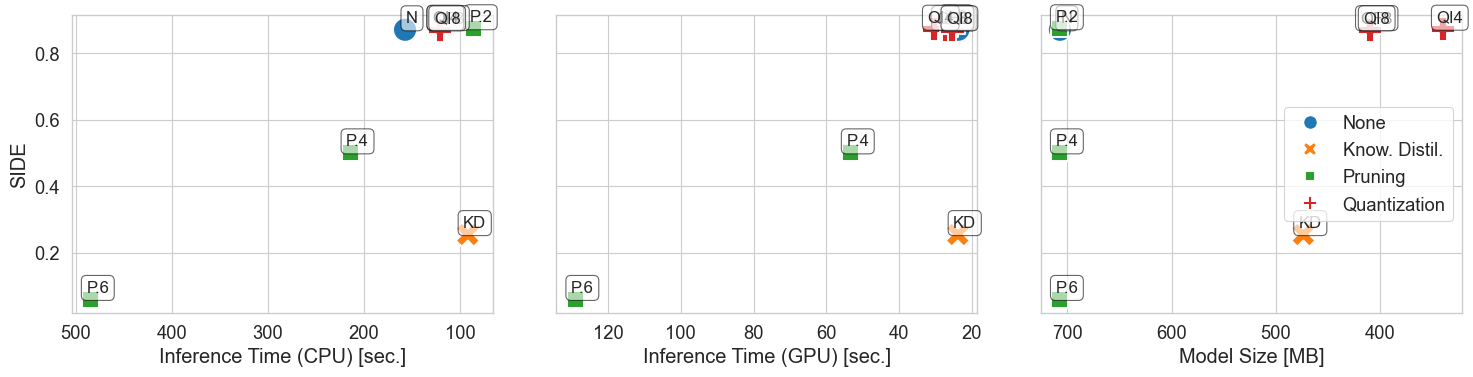

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for metric, ax in zip(
    ["Median Inference Time CPU", "Median Inference Time CUDA", "Model Size"], axs
):
    if metric != "Median Inference Time CPU":
        # hide y label and ticks labels
        ax.set_yticklabels(["" for i in ax.get_yticklabels()])
        ax.set_ylabel(" ")

    sns.scatterplot(
        data=df_,
        x=metric,
        y="SIDE",
        hue="Method",
        style="Method",
        ax=ax,
        legend=(metric == "Model Size"),
        s=300,
        # palette="inferno",
    )

    # remove the legend title if it exists
    # reduce size of the legend symbols

    if metric == "Model Size":
        ax.legend(title=None, markerscale=0.6)

    # reverse the x-axis
    ax.invert_xaxis()
    ax.set_xlabel(xlabels[metric])

    # add the acronyms to the plot
    for i, row in df_.iterrows():
        ax.annotate(
            acronyms[row["Compression Method"]],
            (row[metric], row["SIDE"]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="center",
            fontsize=12,
            bbox=dict(
                facecolor="white",
                alpha=0.6,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ),
        )
        # center on the point and white font
        # ax.text(
        #     row[metric],
        #     row["Bleu"],
        #     acronyms[row["Compression Method"]],
        #     fontsize=10,
        #     ha="center",
        #     va="center",
        #     color="black",
        # )
plt.tight_layout()
plt.savefig("figures/summarization_tradeoff.pdf")

# Code Search

In [97]:
df_ = df[df["Task"] == "Code Search"]

df_ = df_.pivot(index="Compression Method", columns="Parameter", values="Value")
df_ = df_.reindex(methods_order)

df_["Method"] = df_.index.map(
    lambda x: (
        "Pruning"
        if x.startswith("Pruning")
        else ("Quantization" if x.startswith("Quantization") else x)
    )
)

stat_tc = stat[stat["task"] == "tc"]

In [98]:
table, table_eff = make_tables(df_, stat_tc, ["MRR", "MRR@1", "MRR@5"])

table.to_latex("tables/search_acc.tex", escape=False, index=False)
table_eff.to_latex("tables/search_time_size.tex", escape=False, index=False)

In [99]:
df_.reset_index(inplace=True)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_4723/559459213.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_4723/559459213.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])


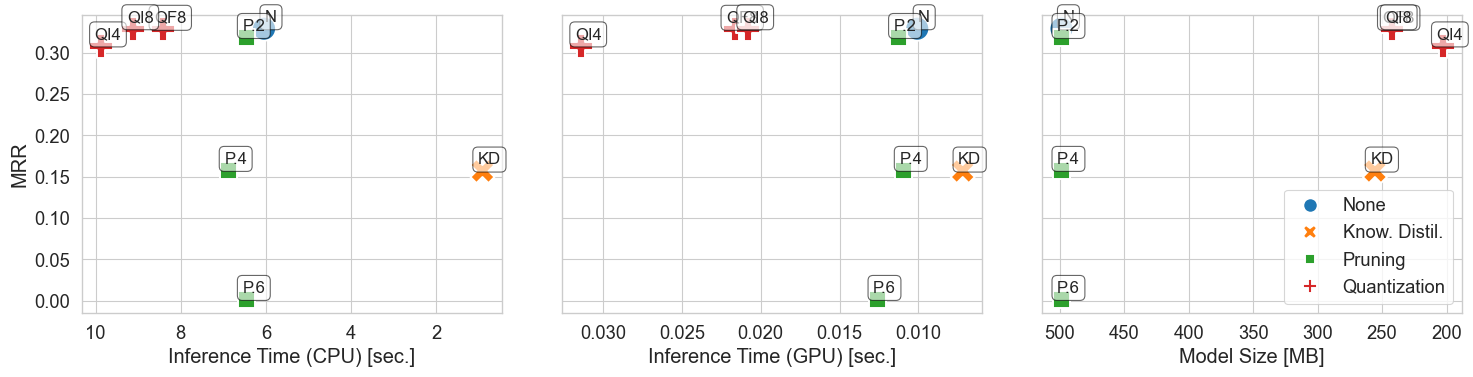

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for metric, ax in zip(
    ["Median Inference Time CPU", "Median Inference Time CUDA", "Model Size"], axs
):
    if metric != "Median Inference Time CPU":
        # hide y label and ticks labels
        ax.set_yticklabels(["" for i in ax.get_yticklabels()])
        ax.set_ylabel(" ")

    sns.scatterplot(
        data=df_,
        x=metric,
        y="MRR",
        hue="Method",
        style="Method",
        ax=ax,
        legend=(metric == "Model Size"),
        s=300,
        # palette="inferno",
    )

    # remove the legend title if it exists
    # reduce size of the legend symbols

    if metric == "Model Size":
        ax.legend(title=None, markerscale=0.6)

    # reverse the x-axis
    ax.invert_xaxis()
    ax.set_xlabel(xlabels[metric])

    # add the acronyms to the plot
    for i, row in df_.iterrows():
        # center on the point and white font
        # ax.text(
        #     row[metric],
        #     row["MRR"],
        #     acronyms[row["Compression Method"]],
        #     fontsize=10,
        #     ha="center",
        #     va="center",
        #     color="black",
        # )
        ax.annotate(
            acronyms[row["Compression Method"]],
            (row[metric], row["MRR"]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="center",
            fontsize=12,
            bbox=dict(
                facecolor="white",
                alpha=0.6,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ),
        )
plt.tight_layout()
plt.savefig("figures/code_search_tradeoff.pdf")